# Self-Driving Car Engineer Nanodegree
---

## Project 3: Build a Traffic Sign Recognition Classifier


## Imports

In [1]:
import numpy as np
import pandas as pd

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Flatten, Dense, Lambda, ELU, Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.layers.normalization import BatchNormalization 

import csv
import cv2

import matplotlib.pyplot as plt
import matplotlib

# Use ggplot as default style for plots
matplotlib.style.use('ggplot')

Using TensorFlow backend.


## Peek Inside the Data

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


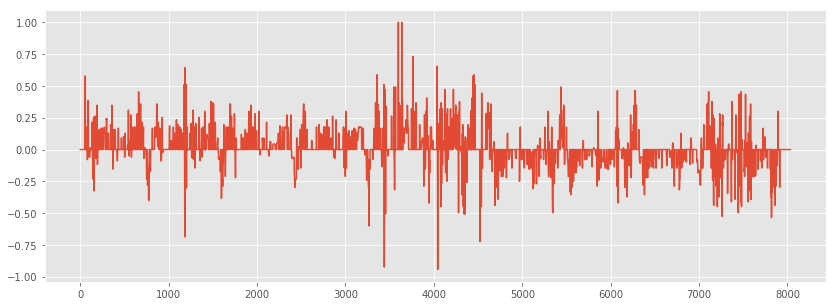

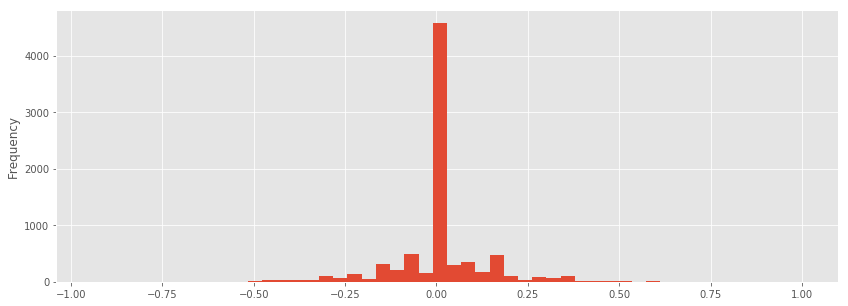

In [2]:
# Data path
csv_path = 'Data/driving_log.csv'
 
# Get CSV steering values
df = pd.read_csv(csv_path)
plt.figure(figsize = (14,5))

# Distribution and histogram of steering angles
df['steering'].plot(kind='line')
plt.figure(figsize = (14,5))
df['steering'].plot(kind='hist', bins=50)

# Basic statistics
df.describe()

## Data Filtering

In [3]:
def load_data(csv_path, random_state):
    '''
    Load a csv file into a pandas dataframe
    
    Parameters:
        - csv_path: Path of the csv file
        - random_state: Random state to ensure the reproducibility
        
    Output:
        - data frame with the data
    '''
    data_frame = pd.read_csv(csv_path)
    # Shuffle and reset the index
    data_frame = data_frame.sample(frac = 1, random_state = random_state).reset_index(drop=True)
    return data_frame


def filter_dataset(data_frame, threshold, fraction, training_split, random_state):
    '''
    Remove steering values close to 0 and replicate them with extreme values
    for a better distribution.
    
    Parameters:
        - data_frame: Data frame to be filtered
        - threshold: Threshold of the values to be removed
        - fraction: Fraction of the values to be removed
        - training_split: Fraction of the dataframe that will
                          be used for training
        - random_state: Random state to ensure the reproducibility
        
    Output:
        - training_data: Training data frame
        - validation_data: Validation data frame
        - data_frame: Data frame of all data
    '''
    # Remove values close to 0
    data_frame = filter_steering(data_frame, threshold, fraction, random_state)

    # Replicate rows having extreme values of steering angles
    data_frame = extend_steering_with_extreme_values(data_frame)
    
    # Build dataframes
    num_rows_training = int(data_frame.shape[0] * training_split)
    training_data = data_frame.loc[0 : num_rows_training - 1]
    validation_data = data_frame.loc[num_rows_training:]
    return training_data, validation_data, data_frame


def filter_steering(data_frame, threshold, fraction, random_state):
    '''
    Remove values whose steering value is less that a given threshold
    
    Parameters:
        - data_frame: Data frame to be filtered
        - threshold: Threshold of the values to be removed
        - fraction: Fraction of the values to be removed
        - random_state: Random state to ensure the reproducibility
    
    Output:
        - data frame filtered
    '''
    
    print ('Number of values less than {} : {}'.format(threshold,
                                                       len(data_frame.loc[data_frame['steering'] < threshold])))
    
    # Build new dataframe, removing only a fraction of the values that met the threshold criteria
    data_frame = data_frame.drop(data_frame[data_frame['steering'] < threshold]
                                 .sample(frac = fraction, random_state = random_state).index)
    
    print('Length of dataframe after droping values: {}'.format(len(data_frame)))
    return data_frame


def extend_steering_with_extreme_values(data_frame):
    '''
    Extend the given steering dataframe with extreme values
    for a better generalization.
    
    Parameters:
        - data_frame: Data frame to be extended
    
    Output:
        - extended data frame for positive and negative steering values
    '''
    # Positive steering
    data_frame_0_10 = data_frame.loc[(data_frame['steering'] >= 0.008) & (data_frame['steering'] <  0.10)]
    data_frame_10_20 = data_frame.loc[(data_frame['steering'] >= 0.10) & (data_frame['steering'] <  0.20)]
    data_frame_20_30 = data_frame.loc[(data_frame['steering'] >= 0.20) & (data_frame['steering'] <  0.30)]
    data_frame_30_40 = data_frame.loc[(data_frame['steering'] >= 0.30) & (data_frame['steering'] <  0.40)]
    data_frame_40_50 = data_frame.loc[(data_frame['steering'] >= 0.40) & (data_frame['steering'] <  0.50)]
    data_frame_50 = data_frame.loc[data_frame['steering'] >= 0.50]

    data_frame = data_frame.append([data_frame_0_10]*3,ignore_index=True)
    data_frame = data_frame.append([data_frame_10_20]*2,ignore_index=True)
    data_frame = data_frame.append([data_frame_20_30]*8,ignore_index=True)
    data_frame = data_frame.append([data_frame_30_40]*6,ignore_index=True)
    data_frame = data_frame.append([data_frame_40_50]*8,ignore_index=True)
    data_frame = data_frame.append([data_frame_50]*60,ignore_index=True)

    # Negative steering
    data_frame_neg_1_10 = data_frame.loc[(data_frame['steering'] <= -0.008) & (data_frame['steering'] >  -0.10)]
    data_frame_neg_10_20 = data_frame.loc[(data_frame['steering'] <= -0.10) & (data_frame['steering'] >  -0.20)]
    data_frame_neg_20_30 = data_frame.loc[(data_frame['steering'] <= -0.20) & (data_frame['steering'] >  -0.30)]
    data_frame_neg_30_40 = data_frame.loc[(data_frame['steering'] <= -0.30) & (data_frame['steering'] >  -0.40)]
    data_frame_neg_40_50 = data_frame.loc[(data_frame['steering'] <= -0.40) & (data_frame['steering'] >  -0.50)]
    data_frame_neg_50 = data_frame.loc[data_frame['steering'] <= -0.50]

    data_frame = data_frame.append([data_frame_neg_1_10] * 8,ignore_index=True)
    data_frame = data_frame.append([data_frame_neg_10_20] * 8,ignore_index=True)
    data_frame = data_frame.append([data_frame_neg_20_30] * 20,ignore_index=True)
    data_frame = data_frame.append([data_frame_neg_30_40] * 20,ignore_index=True)
    data_frame = data_frame.append([data_frame_neg_40_50] * 20,ignore_index=True)
    data_frame = data_frame.append([data_frame_neg_50] * 80,ignore_index=True)
    
    return data_frame

Number of values less than 0.01 : 6148
Length of dataframe after droping values: 3732

Data frame after extend steering:


,steering,throttle,brake,speed
count,17142.000000,17142.000000,17142.000000,17142.000000
mean,0.051752,0.870821,0.001719,28.159578
std,0.274208,0.288191,0.037505,5.845755
min,-0.809811,0.000000,0.000000,0.507576
25%,-0.107229,0.985533,0.000000,30.164160
50%,0.042623,0.985533,0.000000,30.184200
75%,0.195719,0.985533,0.000000,30.186340
max,1.000000,0.985533,1.000000,30.384740


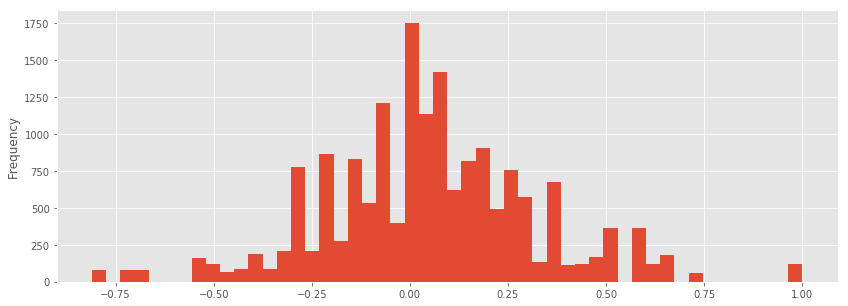

In [4]:
random_state = 17
csv_path = 'Data/driving_log.csv'
threshold = 0.01
fraction_to_be_removed = 0.7
training_split = 0.8

# Load data and build datasets
df = load_data(csv_path, random_state)
df_train, df_valid, df = filter_dataset(df, threshold, fraction_to_be_removed, training_split, random_state)

# Plot new dataframe
plt.figure(figsize = (14,5))
df['steering'].plot(kind='hist', bins=50)

# Statistics of the new dataset
print('\nData frame after extend steering:')
df.describe()

## Preprocess image

In [5]:
def load_image(img_path):
    '''
    Loads an image by reading from a file path
    
    Parameters:
        - img_path: path of the image to load
    
    Output:
        - RGB image
    '''
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def convert_to_HSV(image):
    '''
    Converts an image from RGB to HSV colorspace
    
    Parameters:
        - img: RGB image to be converted
    
    Output:
        - HSV image
    '''
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return image


def resize_image(image, size):
    '''
    Resize an image to the given size
    
    Parameters:
        - image: Image to be resized
        - size: New size of the image
    
    Output:
        - resized image
    '''
    return cv2.resize(image, size)


def crop_image(image, vertical):
    '''
    Crop image vertically
    
    Parameters:
        - image: Image to crop
        - vertical: Top and bottom points to crop
    
    Output:
        - cropped image
    '''
    cropped_image = image[vertical[0]:vertical[1], :, :]
    return cropped_image


def preprocess_image(image, vertical_crop, size):
    '''
    Steps for preprocessing an image before feeding it to 
    the network. It crops, resizes and converts the image
    to HSV colorspace.
    
    Parameters:
        - image: Image to preprocess
        - vertical_crop: Top and bottom points to crop
        - size: New size of the image
    
    Output:
        - preprocessed image
    '''
    image = crop_image(image, vertical_crop)
    image = resize_image(image, size)
    image = convert_to_HSV(image)
    image = np.array(image)
    return image


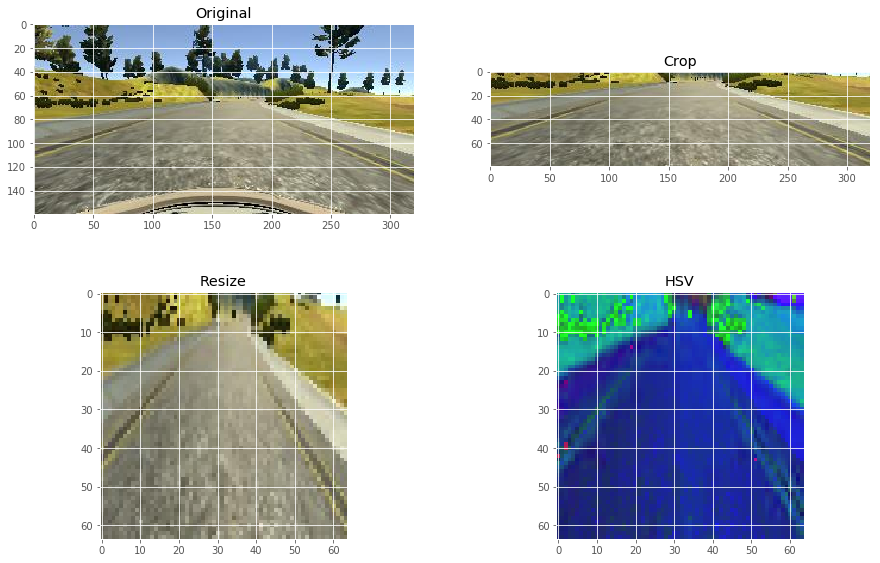

In [6]:
# Path of the first center image
img_path = 'Data/{}'.format(df['center'][0])
vertical_crop = (55, 135)
img_size = (64, 64)

# Images step by step
img = load_image(img_path)
img_crop = crop_image(img, vertical_crop)
img_resize = resize_image(img_crop, img_size)

img_all = preprocess_image(img, vertical_crop, img_size)

# Plot
images = [img, img_crop, img_resize, img_all]
titles = ['Original', 'Crop', 'Resize', 'HSV']

fig, axs = plt.subplots(2,2, figsize = (15,10))
for (i, ax) in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(titles[i])


## Perturb image

In [7]:
def pick_image(row_data, steering_correction):
    '''
    Picks an image from amongst the center, left or right
    side.
    
    Parameters:
        - row_data: CSV row data
        - steering_correction: Correction of the steering angle
    
    Output:
        - img_path: Path of the picked image
        - steering: Corrected steering value
    '''
    # Randomly pick one option
    toss = np.random.randint(3)
    
    # Values to return
    img_path = ''
    steering = 0.0
    
    # Center image
    if toss == 0:
        img_path = row_data.iloc[0]
        steering = row_data.iloc[3]
    
    # Left image
    elif toss==1:
        img_path = row_data.iloc[1]
        steering = row_data.iloc[3] + steering_correction
    
    # Right image
    elif toss==2:
        img_path = row_data.iloc[2]
        steering = row_data.iloc[3] - steering_correction
    
    return img_path, steering


def translate_image(image, steering_angle, range_x = 100, range_y = 10):
    """
    Randomly shift the image vertically and horizontally.
    
    Parameters:
        - image: Image to be shifted
        - steering_angle: Steering angle
        - range_x: Range of transformation for the x axis
        - range_y: Range of transformation for the y axis
    
    Output:
        - image: Warped image
        - steering_angle : Compensated steering angle
    """
    # Random translation values
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    # Compensate steering angle
    steering_angle += trans_x * 0.002
    # Transformation matrix
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    # Warp it
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def increase_brightness(img):
    '''
    Randomly adds brightness to an image.
    
    Parameters:
        - img: Image to treat

    Output:
        - image: Brighter image
    '''
    # Transform to HSV
    imgage = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    # Pick a random value for brightness
    random_bright = .25 + np.random.uniform()
    imgage[:,:,2] = imgage[:,:,2] * random_bright
    # Transform back to RGB
    imgage = cv2.cvtColor(imgage, cv2.COLOR_HSV2RGB)
    return imgage


def random_shadow(image):
    """
    Generates a random shadow in an image.
    
    Parameters:
        - img: Image to treat

    Output:
        - image with shadow
    """
    height, width = image.shape[:2]
    
    # (x1, y1) and (x2, y2) forms a line. xm, ym gives all the locations of the image
    x1, y1 = width * np.random.rand(), 0
    x2, y2 = width * np.random.rand(), height
    xm, ym = np.mgrid[0:height, 0:width]

    # Mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # Choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low = 0.2, high = 0.5)

    # Adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def perturb_image(row_data, steering_correction, vertical_crop, size):
    '''
    Perturbs an image by translating, adding random shadow, increasing
    brightness and preprocessing (crop , resize and conversion to HSV space) it.
    
    Parameters:
        - row_data: CSV row data
        - steering_correction: Correction of the steering angle
        - vertical_crop: Top and bottom points to crop
        - size: New size of the image
        
    Output:
        - image: Perturbed image
        - steering: Steering value of the image
    ''' 
    # Pick an image
    img_path, steering = pick_image(row_data, steering_correction)
    image = load_image(img_path)

    # Translate image
    image, steering = translate_image(image, steering)
    
    # Increase brightness
    image = increase_brightness(image)

    # Flip image. This is done to reduce the bias for 
    # turning left that is present in the training data
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        # Flip the image and reverse the steering angle
        steering = -1 * steering
        image = cv2.flip(image, 1)

    # Random shadow
    image = random_shadow(image)

    # Preprocess image
    image = preprocess_image(image, vertical_crop, size)
   
    return image, steering

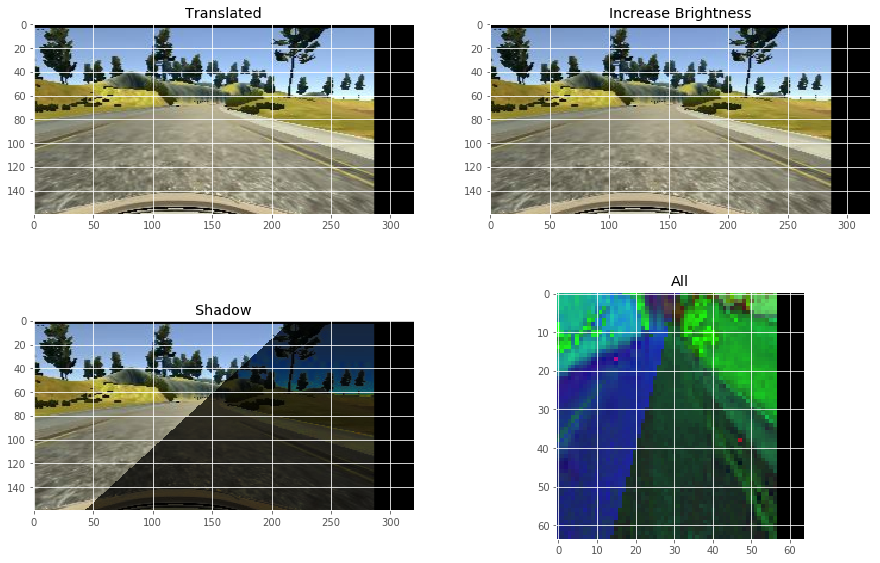

In [9]:
img_path = 'Data/{}'.format(df['center'][0])
vertical_crop = (55, 135)
img_size = (64, 64)

# Images step by step
img = load_image(img_path)
img_translated, _ = translate_image(img, 0)
img_brightness = increase_brightness(img_translated)
img_shadow = random_shadow(img_brightness)
img_perturbed = preprocess_image(img_shadow, vertical_crop, img_size)

# Plot
images = [img_translated, img_brightness, img_shadow, img_perturbed]
titles = ['Translated', 'Increase Brightness', 'Shadow', 'All']

fig, axs = plt.subplots(2,2, figsize = (15,10))
for (i, ax) in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(titles[i])


## Generator

In [ ]:
def get_data_generator(data_frame, batch_size, steering_correction, vertical_crop, size):
    '''
    Generates data for the model on the fly.
    
    Parameters:
        - data_frame: Dataframe that contains the training set
        - batch_size: Desired size of each batch to feed the CNN
        - steering_correction: Correction of the steering angle
        - vertical_crop: Top and bottom points to crop
        - size: New size of the image
        
    Output:
        - image: Perturbed image
        - steering: Steering value of the image
    '''
    
    print("---- Data Generator Active ----")
    N = data_frame.shape[0]
    batches_per_epoch = N // batch_size
    print("Number of samples: {}".format(N))
    print("Batches per epoch: {}".format(batches_per_epoch))

    i = 0
    while(True):
        start = i * batch_size
        end = start + batch_size - 1
        
        # Batches to return
        X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        j = 0

        # slice a `batch_size` sized chunk from the dataframe
        # and perturb data for each row in the chunk on the fly
        for index, row in data_frame.loc[start:end].iterrows():
            image, steering =  perturb_image(row, steering_correction, vertical_crop, size)
            X_batch[j]  = image
            y_batch[j] = steering
            j += 1

        i += 1
        # If epoch finished reset the index to start all over again
        if i == batches_per_epoch - 1:
            i = 0
            
        yield X_batch, y_batch

## Model

In [ ]:
def get_model(input_shape, activation):
    """
    Generates the CNN model.
    
    Parameters:
        - input_shape: Input shape of the network
        - activation: Activation function to use

    Output:
        - CNN model
    """
    model = Sequential()
    
    model.add(Conv2D(3, 1, 1, subsample=(2, 2), input_shape = input_shape, activation = activation, name='cv0'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(16, 3, 3, activation = activation, name = 'cv1'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(name='maxPool_cv1'))
    model.add(Dropout(0.3, name='dropout_cv1'))

    model.add(Conv2D(32, 3, 3, activation = activation, name = 'cv2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(name='maxPool_cv2'))
    model.add(Dropout(0.5, name='dropout_cv2'))

    model.add(Conv2D(64, 3, 3, activation = activation, name = 'cv3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(name='maxPool_cv3'))
    model.add(Dropout(0.5, name='dropout_cv3'))

    model.add(Flatten())

    model.add(Dense(1000, activation = activation, name = 'fc1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, name='dropout_fc1'))

    model.add(Dense(100, activation = activation, name = 'fc2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, name='dropout_fc2'))

    model.add(Dense(10, activation = activation, name = 'fc3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, name='dropout_fc3'))

    model.add(Dense(1, name='output'))
    return model

In [86]:
# Parameters
input_shape = (64, 64, 3)
activation = 'elu'

model = get_model(input_shape, activation)
model.summary()

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 1), strides=(2, 2), input_shape=(64, 64, 3..., activation="elu", name="cv0")`
  
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="elu", name="cv1")`
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="elu", name="cv2")`
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu", name="cv3")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cv0 (Conv2D)                 (None, 32, 32, 3)         12        
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
cv1 (Conv2D)                 (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
maxPool_cv1 (MaxPooling2D)   (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_cv1 (Dropout)        (None, 15, 15, 16)        0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 13, 13, 32)        4640      
__________

## Pipeline

In [ ]:
print('Udacity Project 3: Behavioral Cloning')
org_data_frame = load_data()
print('Data loaded')
#get_data_stats(org_data_frame)

train_data, valid_data, new_data_frame = filter_dataset(org_data_frame)
print('Data filtered')
#get_data_stats(new_data_frame)

    
    
org_data_frame = None

print('calling generators')
training_generator = get_data_generator(train_data) 
validation_data_generator = get_data_generator(valid_data)
   
model = get_model()

adam = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = 'adam', loss = 'mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')
save_weights = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

model.fit_generator(training_generator, validation_data=validation_data_generator, nb_epoch = EPOCHS, 
callbacks=[save_weights, early_stopping], samples_per_epoch = 20000, nb_val_samples = len(valid_data))
#model.fit(np.array([[1]]), np.array([[2]]), batch_size=BATCH_SIZE, shuffle = True, nb_epoch = EPOCHS, callbacks=[save_weights, early_stopping])
    
#save the model
model.save(MODEL_NAME)
print("Model Saved!")